In [1]:
import random
from copy import deepcopy  # NEW
from typing import Tuple, List, Union

import gym
import numpy as np
import torch
from torch.autograd import Variable
from poutyne import Model
from torch.nn import functional as F
from typing import Tuple, List, Union, Iterable
import matplotlib.pyplot as plt
import os
%matplotlib inline

def show_rewards(R: Iterable, **kwargs):
    plt.plot(R)
    plt.grid()
    title = kwargs.get("title", "Reward per episodes")
    plt.title(title)
    plt.ylabel("Reward [-]")
    plt.xlabel("Episodes [-]")
    os.makedirs("figures/", exist_ok=True)
    plt.savefig(f"figures/TP2_Q1_{title.replace(' ', '_')}.png", dpi=300)
    plt.show(block=kwargs.get("block", True))

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.__buffer_size = buffer_size
        # TODO : Add any needed attributes
        self.data: List[Tuple[np.ndarray, int, float, np.ndarray, bool]] = []  # List[(s, a, r, next_s, episode_done)]

    def store(self, element: Tuple[np.ndarray, int, float, np.ndarray, bool]):
        """
        Stores an element. If the replay buffer is already full, deletes the oldest
        element to make space.
        """
        # TODO : Implement
        if len(self.data) >= self.__buffer_size:
            self.data.pop(0)

        self.data.append(element)

    def get_batch(self, batch_size: int) -> List[Tuple[np.ndarray, int, float, np.ndarray, bool]]:
        """
        Returns a list of batch_size elements from the buffer.
        """
        # TODO : Implement
        # print(f"self.data[0][0].shape: {self.data[0][0].shape}")

        return random.choices(self.data, k=batch_size)


class DQN(Model):
    def __init__(self, actions, *args, **kwargs):
        self.actions = actions
        super().__init__(*args, **kwargs)

    def get_action(self, state: Union[torch.Tensor, np.ndarray], epsilon: float) -> int:
        """
        Returns the selected action according to an epsilon-greedy policy.
        """
        # print(f"state: {state[np.newaxis, :].shape}")
        # TODO: implement
        if np.random.random() < epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.predict(state[np.newaxis], batch_size=1))#.squeeze()).item()

    def soft_update(self, other, tau):
        """
        Code for the soft update between a target network (self) and
        a source network (other).

        The weights are updated according to the rule in the assignment.
        """
        new_weights = {}

        own_weights = self.get_weight_copies()
        other_weights = other.get_weight_copies()

        for k in own_weights:
            new_weights[k] = (1 - tau) * own_weights[k] + tau * other_weights[k]

        self.set_weights(new_weights)


class NNModel(torch.nn.Module):
    """
    Neural Network with 3 hidden layers of hidden dimension 64.
    """

    def __init__(self, in_dim, out_dim, n_hidden_layers=3, hidden_dim=64):
        super().__init__()
        if n_hidden_layers>0:
            layers = [torch.nn.Linear(in_dim, hidden_dim), torch.nn.ReLU()]
            for _ in range(n_hidden_layers - 1):
                layers.extend([torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()])
            layers.append(torch.nn.Linear(hidden_dim, out_dim))
        else:
            layers = [torch.nn.Linear(in_dim, out_dim)]

        self.fa = torch.nn.Sequential(*layers)

    def forward(self, x):
        # print(x.shape)
        return self.fa(x)


def format_batch(
        batch: List[Tuple[np.ndarray, int, float, np.ndarray, bool]],
        target_network: DQN,
        gamma: float
) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
    """
    Input : 
        - batch, a list of n=batch_size elements from the replay buffer
        - target_network, the target network to compute the one-step lookahead target
        - gamma, the discount factor

    Returns :
        - states, a numpy array of size (batch_size, state_dim) containing the states in the batch
        - (actions, targets) : where actions and targets both
                      have the shape (batch_size, ). Actions are the 
                      selected actions according to the target network
                      and targets are the one-step lookahead targets.
    """
    # TODO: Implement
    states = np.array([e[0] for e in batch])
    actions = np.array([e[1] for e in batch])
    next_states = np.array([e[3] for e in batch])
    
    
    target_predictions = target_network.predict(next_states, batch_size=len(next_states))
    dones = np.array([e[4] for e in batch])
    target_predictions[dones] = 0

    targets = np.array([e[2] + gamma * np.max(q) for e, q in zip(batch, target_predictions)])

    return states, (actions, targets)


def dqn_loss(y_pred: torch.Tensor, y_target: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
    """
    Input :
        - y_pred, (batch_size, n_actions) Tensor outputted by the network
        - y_target = (actions, targets), where actions and targets both
                      have the shape (batch_size, ). Actions are the 
                      selected actions according to the target network
                      and targets are the one-step lookahead targets.

    Returns :
        - The DQN loss 
    """
    # TODO: Implement
    target_actions, targets = y_target

    return torch.mean(torch.pow(targets.detach() - y_pred[np.arange(len(y_pred)), target_actions], 2))
    

def set_random_seed(environment, seed):
    environment.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # NEW
    random.seed(seed)

In [2]:
batch_size=32
gamma=0.99
buffer_size=int(1e5)
seed=42
tau=1e-1
training_interval=4
lr=1e-4
epsilon_decay=0.99
min_epsilon=0.01
verbose_interval=10
render_interval = verbose_interval

environment = gym.make("LunarLander-v2")
set_random_seed(environment, seed)

actions = list(range(environment.action_space.n))
model = NNModel(environment.observation_space.shape[0], environment.action_space.n)
policy_net = DQN(
    actions,
    model,
    optimizer=torch.optim.Adam(model.parameters(), lr=lr),
    loss_function=dqn_loss,
)

In [3]:
m1 = m2 = deepcopy(policy_net)
m1.load_weights("policy_net_DQN")
m2.load_weights("policy_net_DQN2")

In [4]:
class Ensemble(Model):
    def __init__(self, actions, models, *args, **kwargs):
        self.actions = actions
        self.models = models
        super().__init__(*args, **kwargs)
        
    def average_ensemble(self, state):
        pred_actions = np.zeros((len(self.models), len(self.actions)))
        for i in range(len(self.models)):
            a = self.models[i].predict(state[np.newaxis])
            pred_actions[i] = a
            
        avg_actions = np.mean(pred_actions, axis=0)
        return np.argmax(avg_actions)
    
    def get_action(self, state: Union[torch.Tensor, np.ndarray], epsilon: float) -> int:
        """
        Returns the selected action according to an epsilon-greedy policy.
        """
        # print(f"state: {state[np.newaxis, :].shape}")
        # TODO: implement
        if np.random.random() < epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.predict(state[np.newaxis], batch_size=1))#.squeeze()).item()

    def get_actions(self, state):
        batch_size = state.shape[0]
        actions = []
        for m in self.models:
            pred_actions = m.predict(state)
            actions.append(pred_actions)
        return np.array(actions).reshape((batch_size,len(self.actions)*len(self.models)))
    
    def predict(self, state, batch_size=32):
        pred_actions = self.get_actions(state)
        input_ensemble = self.format_states_actions(state, pred_actions)
        return super().predict(input_ensemble) 
        #return super().predict(state)
    
    def format_states_actions(self, state, pred_actions):
        #return pred_actions#np.concatenate((pred_actions), axis=-1)
        return np.concatenate((pred_actions, state), axis=-1)
    
    def train_on_batch(self, x, y):
        #print(self.format_states_actions(x, self.get_actions(x)).shape)
        return super().train_on_batch(self.format_states_actions(x, self.get_actions(x)), y)
    
    def soft_update(self, other, tau):
        """
        Code for the soft update between a target network (self) and
        a source network (other).

        The weights are updated according to the rule in the assignment.
        """
        new_weights = {}

        own_weights = self.get_weight_copies()
        other_weights = other.get_weight_copies()

        for k in own_weights:
            #print(own_weights[k].shape, other_weights[k].shape)
            new_weights[k] = (1 - tau) * own_weights[k] + tau * other_weights[k]
        self.set_weights(new_weights)

episode: 0, R: -143.63, R_mean: -143.63, epsilon: 1.00
episode: 10, R: 11.14, R_mean: -185.56, epsilon: 0.90


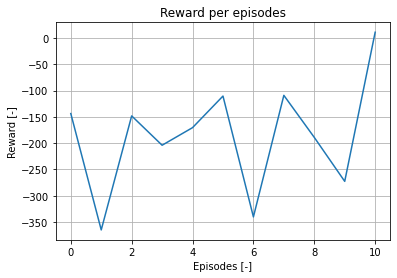

episode: 20, R: -129.92, R_mean: -161.57, epsilon: 0.82


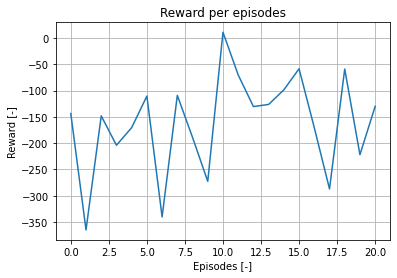

episode: 30, R: -96.55, R_mean: -201.52, epsilon: 0.74


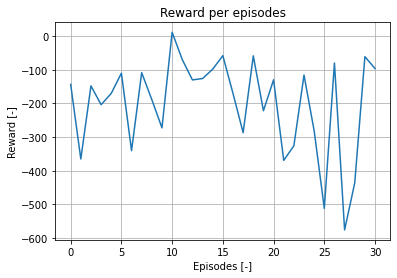

episode: 40, R: -386.13, R_mean: -214.87, epsilon: 0.67


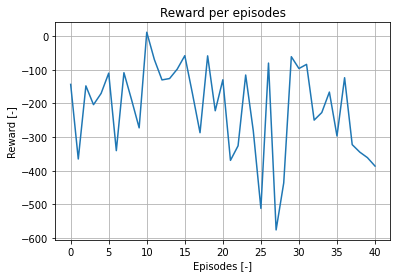

episode: 50, R: -50.20, R_mean: -231.76, epsilon: 0.61


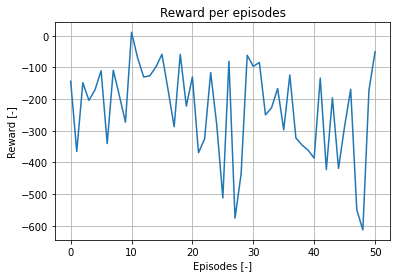

episode: 60, R: -192.79, R_mean: -240.20, epsilon: 0.55


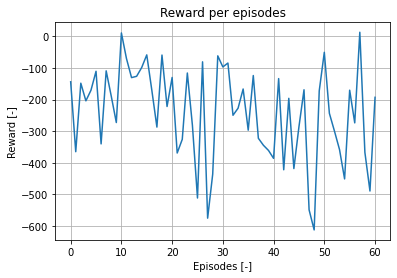

episode: 70, R: -360.06, R_mean: -255.40, epsilon: 0.49


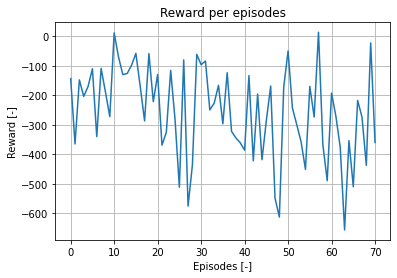

episode: 80, R: -326.98, R_mean: -268.28, epsilon: 0.45


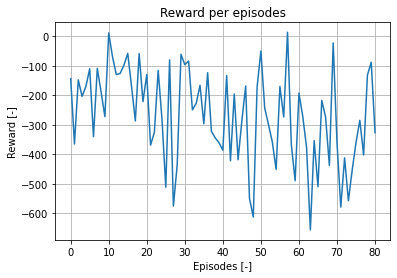

episode: 90, R: -227.63, R_mean: -274.10, epsilon: 0.40


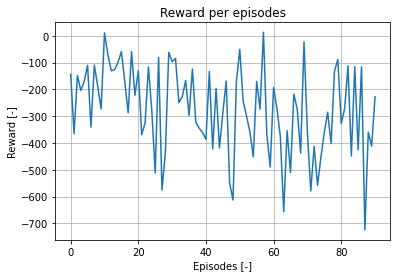

episode: 100, R: -695.94, R_mean: -288.34, epsilon: 0.37


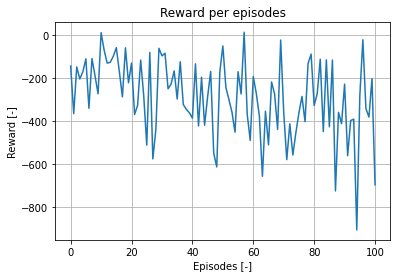

episode: 110, R: -127.67, R_mean: -293.98, epsilon: 0.33


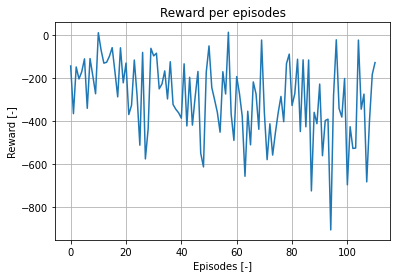

episode: 120, R: -73.68, R_mean: -300.51, epsilon: 0.30


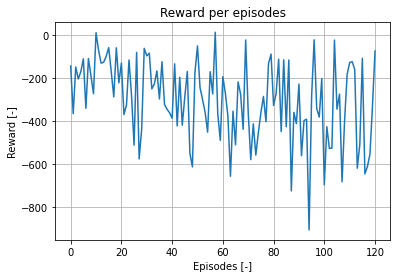

episode: 130, R: -114.74, R_mean: -304.90, epsilon: 0.27


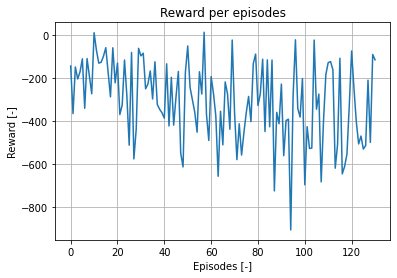

episode: 140, R: -129.89, R_mean: -297.39, epsilon: 0.24


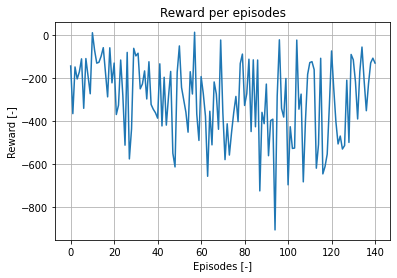

episode: 150, R: -407.26, R_mean: -296.89, epsilon: 0.22


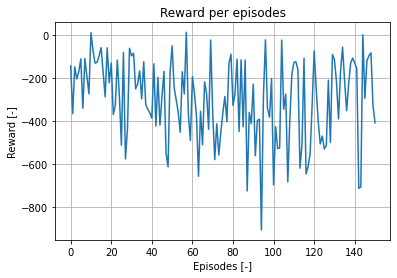

episode: 160, R: -285.40, R_mean: -301.37, epsilon: 0.20


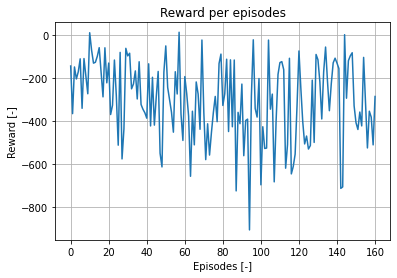

episode: 170, R: -481.92, R_mean: -304.48, epsilon: 0.18


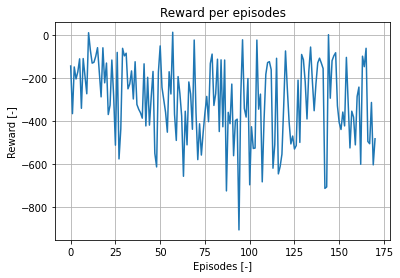

episode: 180, R: -149.68, R_mean: -306.41, epsilon: 0.16


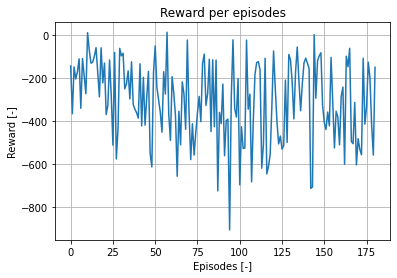

episode: 190, R: -132.75, R_mean: -305.16, epsilon: 0.15


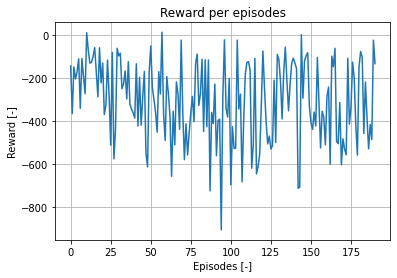

episode: 200, R: -308.24, R_mean: -303.96, epsilon: 0.13


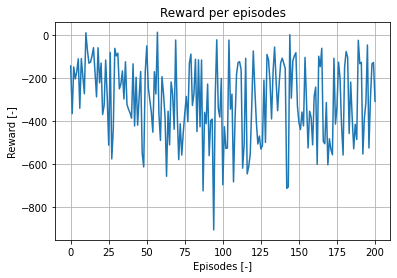

episode: 210, R: -523.90, R_mean: -306.17, epsilon: 0.12


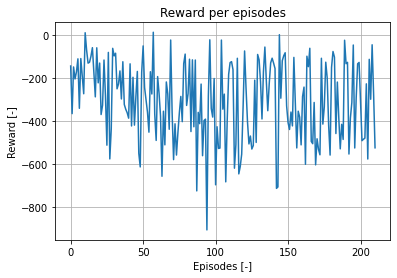

episode: 220, R: -466.42, R_mean: -310.99, epsilon: 0.11


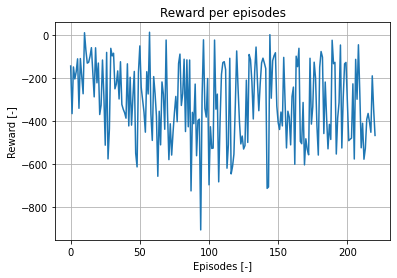

In [ ]:
list_models = [m1, m2]
fusion_model = NNModel(environment.observation_space.shape[0] + environment.action_space.n*len(list_models),
                      environment.action_space.n)

ensemble = Ensemble(actions, list_models,
                    network=fusion_model,
                    optimizer=torch.optim.Adam(fusion_model.parameters(), lr=lr),
                    loss_function=dqn_loss)

target_net = Ensemble(actions, list_models,
                    deepcopy(fusion_model),
                    optimizer="sgd",
                    loss_function=dqn_loss)
replay_buffer = ReplayBuffer(buffer_size)

training_done = False
episodes_done = 0

steps_done = 0
epsilon = 1.0
R_episodes = []
while not training_done:
    s = environment.reset()
    episode_done = False
    R_episode: float = 0.0
    while not episode_done:
        a = ensemble.get_action(s, epsilon)# if np.random.rand() < 0.5 else m2.get_action(s,epsilon)
        next_s, r, episode_done, _ = environment.step(a)
        replay_buffer.store((s, a, r, next_s, episode_done))
        s = next_s
        steps_done += 1

        #print(r)
        if steps_done % training_interval == 0:
            if len(replay_buffer.data) >= batch_size:
                batch = replay_buffer.get_batch(batch_size)
                x, y = format_batch(batch, target_net, gamma)

                #print(x.shape, y[1].shape)
                loss = ensemble.train_on_batch(x, y)
                target_net.soft_update(ensemble, tau)

        R_episode += r
    #print(sum_reward, epsilon)
    # TODO: update epsilon
    R_episodes.append(R_episode)
    if episodes_done % verbose_interval == 0:
        print(f"episode: {episodes_done}, R: {R_episode:.2f},"
              f" R_mean: {np.mean(R_episodes):.2f}, epsilon: {epsilon:.2f}")
    if episodes_done % render_interval == 0 and episodes_done > 0:
        show_rewards(R_episodes, block=False)
    epsilon = max(min_epsilon, epsilon_decay*epsilon)
    episodes_done += 1